# Qiskit Runtime Primitivesを使いこなす！補足ノートブック

## Sampler

https://qiskit.org/ecosystem/ibm-runtime/locale/ja_JP/tutorials/how-to-getting-started-with-sampler.html を改造してます

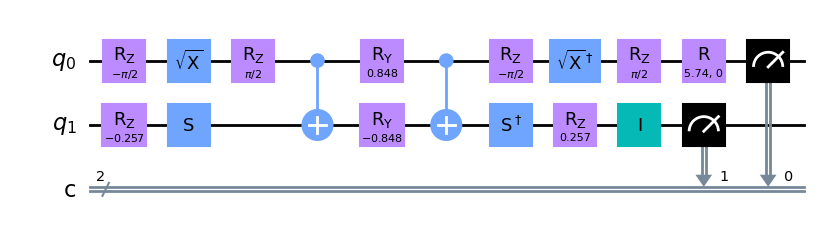

In [1]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0, measure=True).decompose(reps=1)
display(circuit.draw("mpl"))

In [2]:
from qiskit_ibm_runtime import Sampler

sampler = Sampler(backend="ibmq_qasm_simulator")
job = sampler.run(circuit)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cksa5kb7rr4iokg308dg
>>> Job Status: JobStatus.DONE


In [3]:
result = job.result()
print(f">>> {result}")
print(f"  > Quasi-probability distribution: {result.quasi_dists[0].binary_probabilities()}")
print(f"  > Metadata: {result.metadata[0]}")

>>> SamplerResult(quasi_dists=[{2: 0.038, 0: 0.41275, 1: 0.031, 3: 0.51825}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])
  > Quasi-probability distribution: {'10': 0.038, '00': 0.41275, '01': 0.031, '11': 0.51825}
  > Metadata: {'shots': 4000, 'circuit_metadata': {}}


In [4]:
# オプションの設定

from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 1 # M3
options.optimization_level = 3
options.execution.shots = 8192

In [5]:
sampler = Sampler(backend="ibmq_qasm_simulator", options=options)
job = sampler.run(circuit)

In [6]:
result = job.result()
print(f">>> {result}")
print(f"  > Quasi-probability distribution: {result.quasi_dists[0].binary_probabilities()}")
print(f"  > Metadata: {result.metadata[0]}")

>>> SamplerResult(quasi_dists=[{0: 0.4161376953125, 1: 0.0311279296875, 2: 0.042724609375, 3: 0.510009765625}], metadata=[{'shots': 8192, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.008616014005383477}])
  > Quasi-probability distribution: {'00': 0.4161376953125, '01': 0.0311279296875, '10': 0.042724609375, '11': 0.510009765625}
  > Metadata: {'shots': 8192, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.008616014005383477}


# Estimator

https://qiskit.org/ecosystem/ibm-runtime/locale/ja_JP/tutorials/how-to-getting-started-with-estimator.html

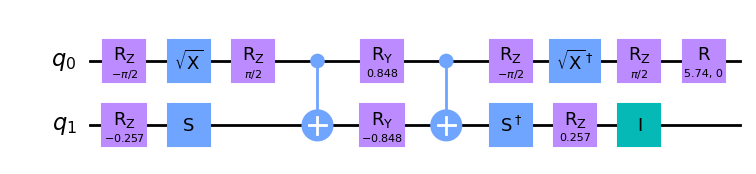

In [7]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

In [8]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("XZ")
observable

SparsePauliOp(['XZ'],
              coeffs=[1.+0.j])

In [9]:
from qiskit_ibm_runtime import Estimator

estimator = Estimator(backend="ibmq_qasm_simulator")

In [10]:
job = estimator.run(circuit, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cksa5qdunk5mjfjjo640
>>> Job Status: JobStatus.RUNNING


In [11]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> EstimatorResult(values=array([0.503]), metadata=[{'variance': 0.746991, 'shots': 4000}])
  > Expectation value: 0.503
  > Metadata: {'variance': 0.746991, 'shots': 4000}


## エラー抑制とエラー緩和

https://qiskit.org/ecosystem/ibm-runtime/locale/ja_JP/tutorials/Error-Suppression-and-Error-Mitigation.html

Trotter circuit with 1 Trotter steps


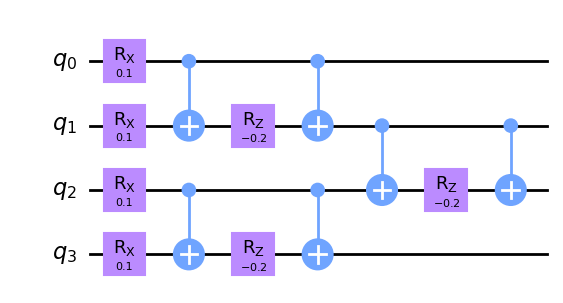

Trotter circuit with 2 Trotter steps


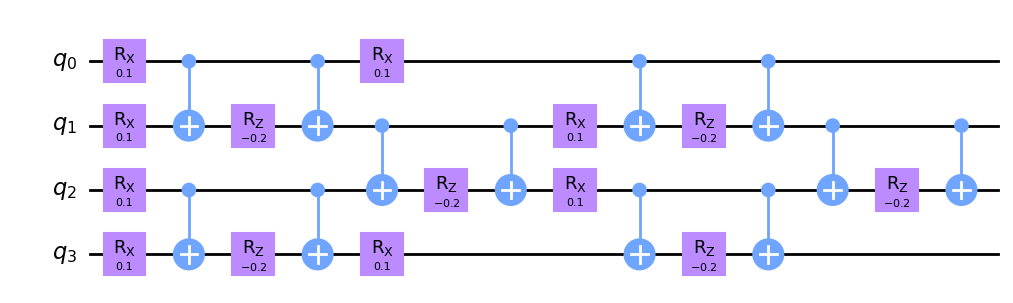

Trotter circuit with 3 Trotter steps


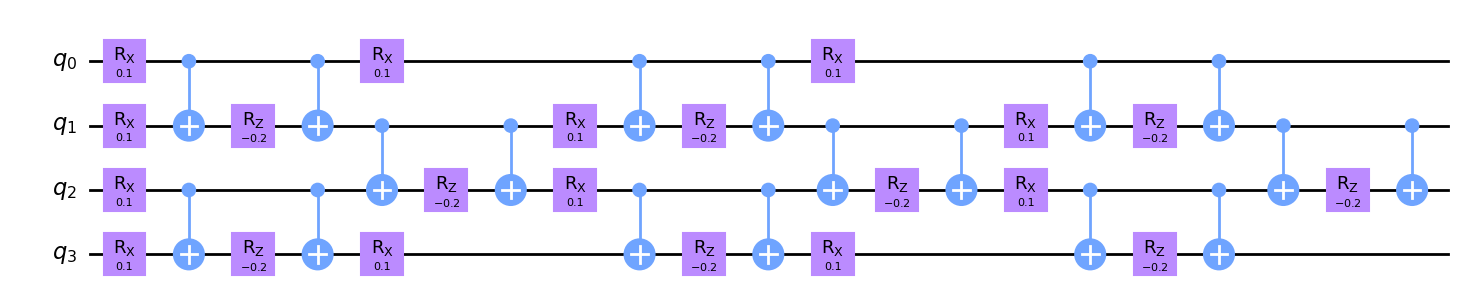

Trotter circuit with 4 Trotter steps


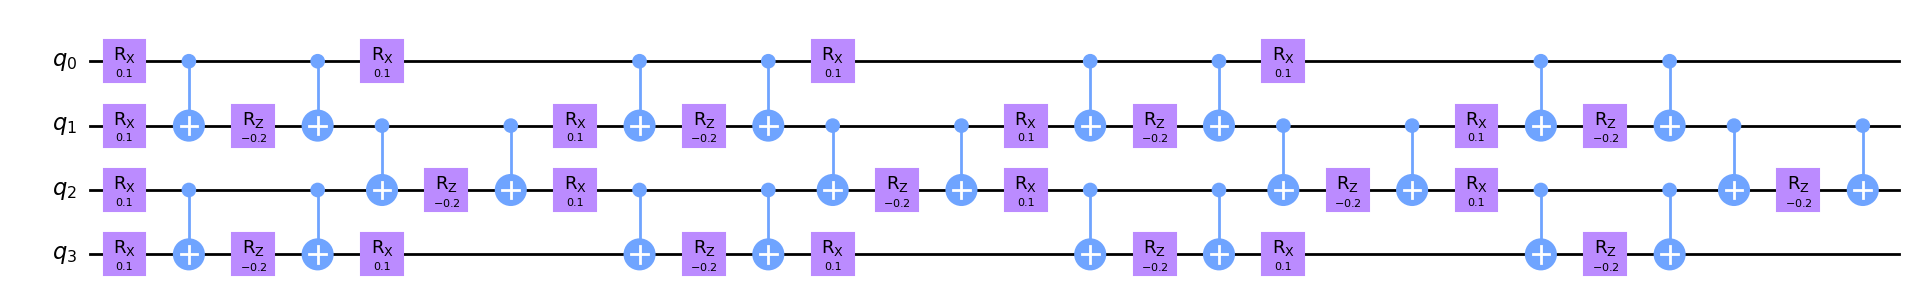

Trotter circuit with 5 Trotter steps


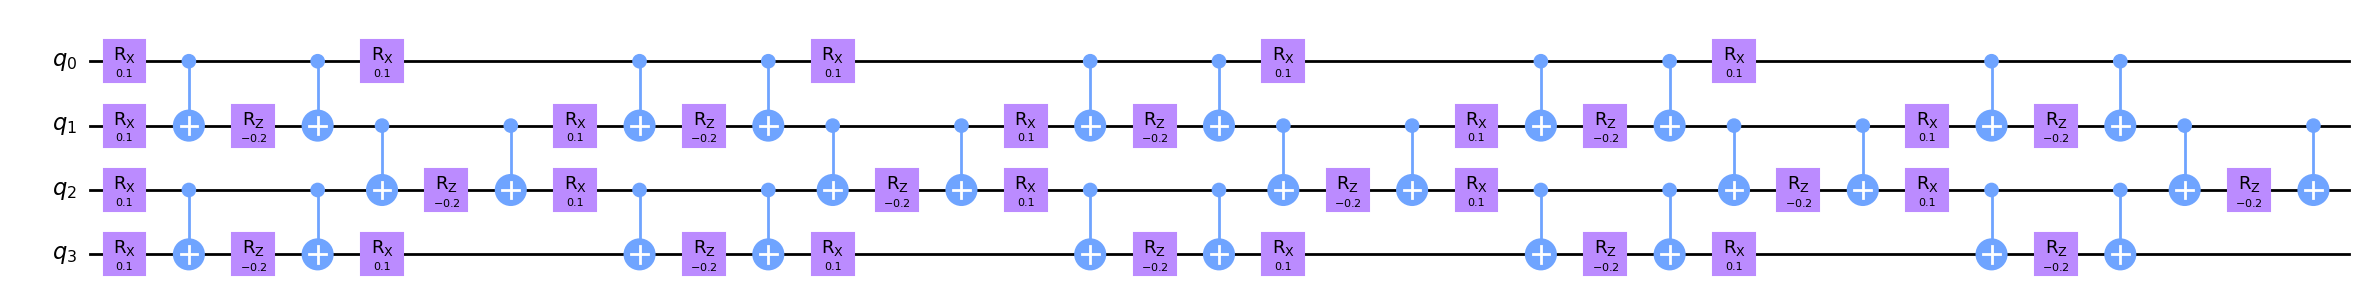

In [12]:
from qiskit import QuantumCircuit

backend_simulator = "ibmq_qasm_simulator"
backend = "ibmq_montreal"

qubits = 4
trotter_layer = QuantumCircuit(qubits)
trotter_layer.rx(0.1, range(qubits))
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.rz(-0.2, [1, 3])
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.cx(1, 2)
trotter_layer.rz(-0.2, 2)
trotter_layer.cx(1, 2)

num_steps = 6
trotter_circuit_list = []
for i in range(1, num_steps):
    trotter_circuit = QuantumCircuit(qubits)
    for _ in range(i):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    trotter_circuit_list.append(trotter_circuit)
    print(f"Trotter circuit with {i} Trotter steps")
    display(trotter_circuit.draw(fold=-1))

obs = SparsePauliOp("Z" * qubits)
obs_list = [obs] * len(trotter_circuit_list)

In [13]:
from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 2 # ZNE
options.optimization_level = 0

# ノイズシミュレータの使い方 https://qiskit.org/ecosystem/ibm-runtime/locale/ja_JP/how_to/noisy_simulators.html
from qiskit.providers.fake_provider import FakeManila
# Make a noise model
fake_backend = FakeManila()
# Set options to include the noise model
options.simulator.set_backend(fake_backend)
options.simulator.seed_simulator = 42

In [14]:
estimator = Estimator(backend="ibmq_qasm_simulator", options=options)
result = estimator.run(trotter_circuit_list, obs_list).result()
print(f">>> Expectation value: {result.values}")
print(f">>> Metadata: {result.metadata}")

>>> Expectation value: [0.78116667 0.73016667 0.67429167 0.60041667 0.527375  ]
>>> Metadata: [{'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [0.789, 0.7655, 0.789], 'variance': [0.3774789999999999, 0.41400975000000007, 0.3774789999999999], 'shots': [4000, 4000, 4000]}, 'extrapolation': {'extrapolator': 'LinearExtrapolator'}}}, {'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>", 'noise_factors': [1, 3, 5], 'values': [0.7355, 0.7445, 0.7555], 'variance': [0.45903974999999997, 0.44571974999999997, 0.4292197500000001], 'shots': [4000, 4000, 4000]}, 'extrapolation': {'extrapolator': 'LinearExtrapolator'}}}, {'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolera

![](https://qiskit.org/ecosystem/ibm-runtime/locale/ja_JP/_images/tutorials_Error-Suppression-and-Error-Mitigation_45_0.png)